In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import imageio
import torch
import torchvision


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def plot_img_tensor(img, nrow=4):
    """Helper function to plot image tensors.
    
    Args:
        img (torch.Tensor): Image or batch of images of shape 
            (batch_size, channels, height, width).
    """
    img_grid = torchvision.utils.make_grid(img, nrow=nrow)
    plt.imshow(img_grid.cpu().numpy().transpose(1, 2, 0))

# Equivariant Neural Rendering

This notebook contains examples of how to load a trained Equivariant Neural Renderer and use it to infer scene representations from a single image, as well as rendering novel views of the scene.

## Load trained model

In [2]:
from models.neural_renderer import load_model

# Load trained chairs model
model = load_model('trained-models/chairs.pt').to(device)

## Load image

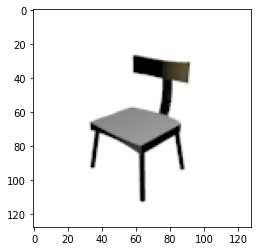

In [3]:
# You can also try loading other examples (e.g. 'chair1.png')
img = imageio.imread('imgs/example-data/chair4.png')
# Visualize image
plt.imshow(img)

## Infer and render scene representation

In [4]:
from torchvision.transforms import ToTensor

# Convert image to tensor and add batch dimension
img_source = ToTensor()(img)
img_source = img_source.unsqueeze(0).to(device)

# Infer scene representation
scene = model.inverse_render(img_source)

# Print scene shape
print("Scene shape: {}".format(scene.shape))

Scene shape: torch.Size([1, 64, 32, 32, 32])


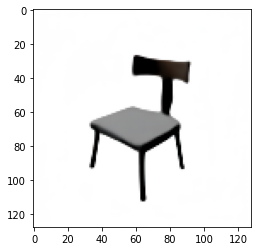

In [5]:
# We can render the scene representation without rotating it
rendered = model.render(scene)

plot_img_tensor(rendered.detach())

## Generate novel views

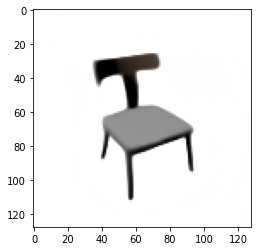

In [6]:
# Initialize a rotation matrix
rotation_matrix = torch.Tensor(
   [[[ 0.4198, -0.3450, -0.8395],
     [-0.2159,  0.8605, -0.4615],
     [ 0.8816,  0.3749,  0.2867]]]
).to(device)

# Rotate scene by rotation matrix
rotated_scene = model.rotate(scene, rotation_matrix)

# Render rotated scene
rendered = model.render(rotated_scene)

plot_img_tensor(rendered.detach())

In [7]:
# As a rotation matrix can feel a little abstract, we can also reason in terms of 
# camera azimuth and elevation. The initial coordinate at which the source image
# is observed is given by the following azimuth and elevation. Note that these
# are not necessary to generate novel views (as shown above), we just use them 
# for convenience to generate rotation matrices
azimuth_source = torch.Tensor([42.561195]).to(device)
elevation_source = torch.Tensor([23.039995]).to(device)

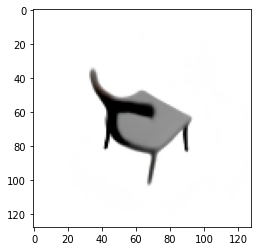

In [8]:
# You can set these to any value you like!
# Positive (negative) values correspond to moving camera to the right (left)
azimuth_shift = torch.Tensor([180.]).to(device)  
# Positive (negative) values correspond to moving camera up (down)
elevation_shift = torch.Tensor([20.]).to(device)

azimuth_target = azimuth_source + azimuth_shift
elevation_target = elevation_source + elevation_shift

# Rotate scene to match target camera angle
rotated_scene = model.rotate_source_to_target(scene, azimuth_source, elevation_source, 
                                              azimuth_target, elevation_target)

# Render rotated scene
rendered = model.render(rotated_scene)

plot_img_tensor(rendered.detach())

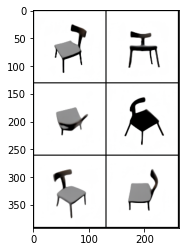

In [9]:
from misc.viz import generate_novel_views

# We can also generate several novel views of the same object
azimuth_shifts = torch.Tensor([20., -50., 120., 180., -90., 50.]).to(device)
elevation_shifts = torch.Tensor([10., -30., 40., -70., 10., 30.]).to(device)

# This function expects a single image as input, so remove batch dimension
views = generate_novel_views(model, img_source[0], azimuth_source, elevation_source,
                             azimuth_shifts, elevation_shifts)

plot_img_tensor(views.detach(), nrow=2)

## Generate novel view animation

In [10]:
from misc.utils import full_rotation_angle_sequence, sine_squared_angle_sequence
from misc.viz import batch_generate_novel_views, save_img_sequence_as_gif

num_frames = 25

azimuth_shifts = full_rotation_angle_sequence(num_frames).to(device)
elevation_shifts = sine_squared_angle_sequence(num_frames, -10., 20.).to(device)

views = batch_generate_novel_views(model, img_source, azimuth_source,
                                   elevation_source, azimuth_shifts,
                                   elevation_shifts)

# Save generated gif (this gif will display in the next cell once it has been saved)
save_img_sequence_as_gif(views, 'novel_views_example.gif')

![chairs-gif](./novel_views_example.gif "chairs-gif")